In [ ]:
from dotenv import load_dotenv
load_dotenv()

import os

In [ ]:
from comet_ml import Experiment, Optimizer

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

torch.set_default_dtype(torch.float32)

In [ ]:
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm

## Declare classes

In [ ]:
class SimpleNetwork(torch.nn.Module):
    def __init__(self, inp_size, layers=[100]):
        super().__init__()
        self.layers = []
        
        self.inp = torch.nn.Linear(inp_size, layers[0])
        self.output = torch.nn.Linear(layers[0], 10)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()
    
    def forward(self, x):
        out = x
        out = self.inp(out)
        out = self.relu(out)
        out = self.output(out)
        return out
    
class LayerBuilder(nn.Module):
    def __init__(self, weights, inp_size, layers=[10]):
        super().__init__(inp_size, layers)
        input_w_size = inp_size*layers[0]
        input_b_size = layers[0]

        hidden_w_size = layers[0]*10
        hidden_b_size = 10

    def forward(self, data):
        out = F.linear(data, self.inp_weights, self.inp_bias)
        out = self.relu(out)
        out = F.linear(out, self.output_weights, self.output_bias)
        return out
    
class MaskedNetwork(SimpleNetwork):
    def __init__(self, input_size, mask_size, layers=[10]):
        super().__init__(mask_size, layers=layers)
        template = np.zeros(input_size)
        mask = np.random.choice(len(template), mask_size, False)
        template[mask] = 1
        self.mask = torch.from_numpy(template).to(torch.bool)
        
    def forward(self, x):
        data = x[:, self.mask]
        return super().forward(data)

In [ ]:
class Hypernetwork(torch.nn.Module):
    def __init__(self, inp_size=784, mask_size=20, node_hidden_size=20, layers=[64, 256], test_nodes=100):
        super().__init__()
        self.device = "cuda"
        
        self.mask_size = mask_size
        self.input_size = inp_size
        self.node_hidden_size = node_hidden_size
        
        input_w_size = mask_size*node_hidden_size
        input_b_size = node_hidden_size

        hidden_w_size = node_hidden_size*10
        hidden_b_size = 10
            
        self.out_size = input_w_size+input_b_size+hidden_w_size+hidden_b_size
        
        self.input = torch.nn.Linear(inp_size, layers[0])
        self.hidden1 = torch.nn.Linear(layers[0], layers[1])
        self.out = torch.nn.Linear(layers[1], self.out_size)
        
        self.relu = torch.nn.ReLU()
        self.template = np.zeros(inp_size)
        self.test_nodes = test_nodes
        self.test_mask = self._create_mask(test_nodes)
        
    def to(self, device):
        super().to(device)
        self.device = device
        self.test_mask = self._create_mask(self.test_nodes)
        return self
        
    def forward(self, data, mask=None):
        """ Get a hypernet prediction.
        
        Args:
            data - prediction input
            mask - either None or a torch.tensor((data.shape[0], data.shape[1])).
        """
        if self.training:
            if mask is None:
                masks = np.array([np.random.choice((len(self.template)), self.mask_size, False) for _ in range(len(data))])
                tmp = np.array([self.template.copy() for _ in range(len(data))])
                for i, mask in enumerate(masks):
                    tmp[i, mask] = 1
                mask = torch.from_numpy(tmp).to(torch.float32).to(self.device)

            weights = self.craft_network(mask)
            res = torch.zeros((len(data), 10)).to(self.device)
            for i in range(len(data)):
                nn = InsertableNet(weights[i], self.mask_size, layers=[self.node_hidden_size])
                masked_data = data[i, mask[i].to(torch.bool)]
                res[i] = nn(masked_data)
            return res
        else:
            if mask is None:
                mask = self.test_mask

            nets = []
            weights = self.craft_network(mask)
            res = torch.zeros((len(data), 10)).to(self.device)
            for i in range(len(mask)):
                nn = InsertableNet(weights[i], self.mask_size, layers=[self.node_hidden_size])
                masked_data = data[:, mask[i].to(torch.bool)]
                res += nn(masked_data)
            res /= self.test_nodes
            return res

#     def forward(self, data, mask=None):
#         if mask is None:
#             mask = np.random.choice(len(template), self.mask_size, False)
#             tmp = self.template.copy()
#             tmp[mask] = 1
#             mask = torch.from_numpy(tmp).to(torch.float32).cuda()
        
#         weights = self.craft_network(mask)
#         nn = InsertableNet(weights, self.mask_size, layers=[self.node_hidden_size])
#         masked_data = data[:, mask.to(torch.bool)]
#         return nn(masked_data)
        
    def _create_mask(self, count):
        masks = np.array([np.random.choice((len(self.template)), self.mask_size, False) for _ in range(count)])
        tmp = np.array([self.template.copy() for _ in range(count)])
        for i, mask in enumerate(masks):
            tmp[i, mask] = 1
        mask = torch.from_numpy(tmp).to(torch.float32).to(self.device)
        return mask
    
    def craft_network(self, mask):
        out = self.input(mask)
        out = self.relu(out)
        out = self.hidden1(out)
        out = self.relu(out)   
        
        out = self.out(out)
        return out

In [102]:
hypernet = Hypernetwork(mask_size=20, node_hidden_size=10).to("cuda")

In [103]:
hypernet.eval()
# print(hypernet(inputs).shape)
# print(hypernet.out_size)

Hypernetwork(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (hidden1): Linear(in_features=64, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=320, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

## Load data

In [7]:
mods = [transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,)),    #mean and std of MNIST
        transforms.Lambda(lambda x: torch.flatten(x))]
mods = transforms.Compose(mods)

trainset = datasets.MNIST(root='./data/train', train=True, download=True, transform=mods)
testset = datasets.MNIST(root='./data/test', train=False, download=True, transform=mods)

In [70]:
class MaskedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, masks, mask_size):
        inputs = dataset[0][0].shape[0]
        self.mask_size = mask_size
        self.dataset = dataset
        self.template = np.zeros(inputs)
        self.masks = self._create_mask(masks)
        self.masks_indices = np.random.choice(np.arange(masks), len(dataset))
        
    def _create_mask(self, count):
        masks = np.array([np.random.choice((len(self.template)), self.mask_size, False) for _ in range(count)])
        tmp = np.array([self.template.copy() for _ in range(count)])
        for i, mask in enumerate(masks):
            tmp[i, mask] = 1
        mask = torch.from_numpy(tmp).to(torch.float32)
        return mask
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        mask = self.masks[self.masks_indices[idx]]
        return image, label, mask
    
masked_trainset = MaskedDataset(trainset, 20, 500)
masked_testset = MaskedDataset(testset, 20, 500)

In [71]:
batch_size = 32
test_batch_size = 1000

trainloader = torch.utils.data.DataLoader(masked_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(masked_testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=1)

## Craft model

In [94]:
def train_loop(hypernet, optimizer, epochs):
    train_loss = []
    test_loss = []
    for epoch in range(epochs): 
        total_loss = 0
        running_loss = 0.0
        correct = 0
        total = 0
        hypernet.train()
        for i, data in enumerate(trainloader):
            inputs, labels, mask = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            mask = mask.cuda()

            optimizer.zero_grad()

            outputs = hypernet(inputs, mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct += (outputs.argmax(1)==labels).float().sum()
            total += outputs.shape[0]
            running_loss += loss.item()
            train_loss.append(loss.item())
            if i>0 and i % 100 == 0:
                total_loss += running_loss/100
                experiment.log_metric("batch_accuracy", correct / total * 100)

                running_loss = 0.0
                correct = 0
                total=0

        total_loss = 0
        correct = 0
        hypernet.eval()
        for i, data in enumerate(testloader):
            images, labels, mask = data
            images = images.cuda()
            labels = labels.cuda()
            mask = mask.cuda()
            
            outputs = hypernet(images, mask)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total_loss += criterion(outputs, labels).item()

        test_loss.append(total_loss/i)
        print(f"Test acc: {correct/len(testset)*100}")
        experiment.log_metric("test_accuracy", correct/len(testset)*100, step=epoch)

In [81]:
criterion = torch.nn.CrossEntropyLoss()

### Verify the model on a preset mask

In [74]:
input_size = 784
mask_size = 500

hypernet = Hypernetwork(mask_size=mask_size, test_nodes=1, node_hidden_size=100).cuda()
hypernet = hypernet.train()

In [75]:
np.random.seed(42)
template = np.zeros(input_size)
mask_idx = np.random.choice(len(template), mask_size, False)
template[mask_idx] = 1
mask = torch.from_numpy(template).to(torch.float32).cuda()
# mask = mask.unsqueeze(0).repeat(batch_size, 1)

In [98]:
epochs = 5
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)
optimizer = torch.optim.SGD(hypernet.parameters(), weight_decay=0.01, momentum=0.5, lr=3e-4)

In [86]:
experiment = Experiment(api_key=os.environ.get("COMET_KEY"), project_name="hypernetwork")
experiment.add_tag("fixed_mask")
experiment.log_parameter("test_nodes", 1)
experiment.log_parameter("mask_size", hypernet.mask_size)

train_loss = []
test_loss = []
for epoch in range(epochs): 
    total_loss = 0
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(tqdm(trainloader)):
        inputs, labels, _ = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        outputs = hypernet(inputs, mask.unsqueeze(0).repeat(len(inputs), 1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        correct += (outputs.argmax(1)==labels).float().sum()
        total += outputs.shape[0]
        running_loss += loss.item()
        train_loss.append(loss.item())
        if i>0 and i % 100 == 0:
            total_loss += running_loss/100
            running_loss = 0.0
            correct = 0
            total=0

    total_loss = 0
    correct = 0
    for i, data in enumerate(testloader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = hypernet(images, mask.unsqueeze(0).repeat(len(images), 1))
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total_loss += criterion(outputs, labels).item()
        
    test_loss.append(total_loss)
    print(f"Test acc: {correct/len(testset)*100}, loss: {total_loss/i}")

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/86bf16bd95a747a3a277e0fd6b373f17
COMET INFO:   Parameters:
COMET INFO:     mask_size  : 500
COMET INFO:     test_nodes : 20
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (111.87 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     os packages              : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


KeyboardInterrupt: 

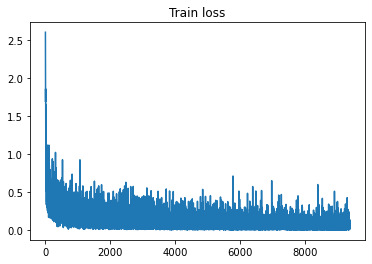

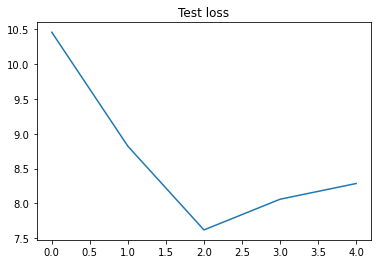

In [54]:
plt.title("Train loss")
plt.plot(train_loss);
plt.show()
plt.title("Test loss")
plt.plot(test_loss);

### Bayesian hyperparam search

In [ ]:
config = {
    "algorithm": "bayes",
    "parameters": {
        "l1": {"type": "categorical", "values": ["64"]},
        "l2": {"type": "categorical", "values": ["128", "256", "512", "1024"]},
#         "l3": {"type": "categorical", "values": ["8", "64", "256", "512"]},
        "learning_rate": {"type": "float", "min": 0.0001, "max": 0.1, "scalingType": "loguniform"},
    },
    "spec": {
    "metric": "loss",
    "objective": "minimize",
    },
}

opt = Optimizer(config, api_key=os.environ.get("COMET_KEY"))
criterion = torch.nn.CrossEntropyLoss()

for experiment in opt.get_experiments(project_name="hypernetwork"):
    experiment.add_tag("optimization")

    test_batch_size = 64

    trainloader = torch.utils.data.DataLoader(masked_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=1)
    testloader = torch.utils.data.DataLoader(masked_testset, batch_size=test_batch_size,
                                             shuffle=False, num_workers=1)
    
    hypernet = Hypernetwork(mask_size=500, layers=[
            int(experiment.get_parameter("l1")), 
            int(experiment.get_parameter("l2"))
    ]).cuda()
    
    
    optimizer = torch.optim.SGD(hypernet.parameters(), weight_decay=0.01, momentum=0.5, lr=experiment.get_parameter("learning_rate"))
    train_loop(hypernet, optimizer, 20)
    experiment.end()

COMET INFO: COMET_OPTIMIZER_ID=98d87b811c484380ab84654ddcfb78bc
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 'infinite', 'endTime': None, 'id': '98d87b811c484380ab84654ddcfb78bc', 'lastUpdateTime': None, 'maxCombo': 0, 'name': '98d87b811c484380ab84654ddcfb78bc', 'parameters': {'l1': {'type': 'categorical', 'values': ['64']}, 'l2': {'type': 'categorical', 'values': ['128', '256', '512', '1024']}, 'learning_rate': {'max': 0.1, 'min': 0.0001, 'scalingType': 'loguniform', 'type': 'float'}}, 'predictor': None, 'spec': {'gridSize': 10, 'maxCombo': 0, 'metric': 'loss', 'minSampleSize': 100, 'objective': 'minimize', 'retryAssignLimit': 0, 'retryLimit': 1000}, 'startTime': 26017589702, 'state': {'mode': None, 'seed': None, 'sequence': [], 'sequence_i': 0, 'sequence_pid': None, 'sequence_retry': 0, 'sequence_retry_count': 0}, 'status': 'running', 'suggestion_count': 0, 'trials': 1, 'version': '2.0.1'}
COMET INFO: ---------------------------
COMET INFO: Comet.ml E

Test acc: 76.85
Test acc: 77.92999999999999
Test acc: 77.9
Test acc: 78.57
Test acc: 79.56
Test acc: 79.14
Test acc: 79.5
Test acc: 80.27
Test acc: 80.04
Test acc: 80.08
Test acc: 78.71000000000001


### Train the full model

In [88]:
batch_size = 32
test_batch_size = 128

masked_trainset = MaskedDataset(trainset, 200, 500)
masked_testset = MaskedDataset(testset, 100, 500)
trainloader = torch.utils.data.DataLoader(masked_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(masked_testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=1)

hypernet = Hypernetwork(mask_size=500, layers=[128, 256, 512], node_hidden_size=100, test_nodes=20).cuda()

In [89]:
experiment = Experiment(api_key=os.environ.get("COMET_KEY"), project_name="hypernetwork")
experiment.add_tag("training")
experiment.log_parameter("test_nodes", hypernet.test_nodes)
experiment.log_parameter("mask_size", hypernet.mask_size)

epochs = 50
optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)
train_loop(hypernet, optimizer, epochs)
# epochs = 50
# optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-5)
# train_loop(hypernet,optimizer, epochs)
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/d99dcd6cd8a245838f7f7370b05e3e6b
COMET INFO:   Uploads:
COMET INFO:     filename           : 1
COMET INFO:     installed packages : 1
COMET INFO:     notebook           : 1
COMET INFO:     os packages        : 1
COMET INFO:     source_code        : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/92c39b8412f1422e9c40cee6dd41d286



Test acc: 83.26
Test acc: 85.45
Test acc: 87.92
Test acc: 89.21
Test acc: 89.41
Test acc: 88.12
Test acc: 89.83
Test acc: 88.9
Test acc: 90.42999999999999
Test acc: 89.95
Test acc: 90.10000000000001
Test acc: 90.09
Test acc: 90.03
Test acc: 90.25999999999999
Test acc: 90.18
Test acc: 89.98
Test acc: 90.05
Test acc: 89.96
Test acc: 90.07
Test acc: 89.97
Test acc: 90.24
Test acc: 89.82
Test acc: 89.77000000000001
Test acc: 90.19
Test acc: 90.38000000000001
Test acc: 90.06
Test acc: 89.75
Test acc: 90.13
Test acc: 89.49000000000001
Test acc: 90.03999999999999
Test acc: 90.36
Test acc: 90.21000000000001
Test acc: 90.41
Test acc: 90.10000000000001
Test acc: 90.21000000000001
Test acc: 90.18
Test acc: 90.35
Test acc: 89.73
Test acc: 89.97
Test acc: 90.38000000000001
Test acc: 90.58
Test acc: 90.14
Test acc: 89.9
Test acc: 90.3
Test acc: 90.08
Test acc: 89.86
Test acc: 90.49000000000001
Test acc: 90.02
Test acc: 90.16999999999999


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/92c39b8412f1422e9c40cee6dd41d286
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_accuracy [900] : (48.42203140258789, 99.44306945800781)
COMET INFO:     loss [9375]          : (3.3176762372022495e-05, 2.17277455329895)
COMET INFO:     test_accuracy [50]   : (83.26, 90.58)
COMET INFO:   Parameters:
COMET INFO:     mask_size  : 500
COMET INFO:     test_nodes : 20
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (132.69 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     model graph              : 1
COMET INFO:     notebook                 : 1
COM

Test acc: 90.31


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 39.89 KB/212.45 KB


In [92]:
def test_model(hypernet, verbose=False):
    correct = 0
    loss = 0
    hypernet.eval()
    for i, data in enumerate(testloader):
        images, labels, mask = data
        images = images.cuda()
        labels = labels.cuda()
        mask = mask.cuda()
        outputs = hypernet(images, mask)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        loss += criterion(outputs, labels).item()

    if verbose:
        print(f"Test acc: {correct/len(testset)*100:.2f}")
        print(f"Test loss: {total_loss/i}")
    return correct/len(testset)*100

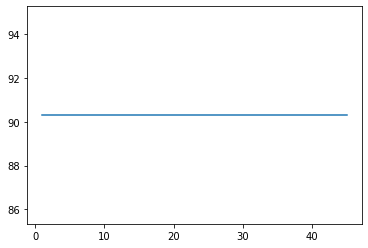

In [93]:
acc = []
nodes = []

for test_nodes in np.arange(1, 10):
    hypernet.test_nodes = test_nodes
    hypernet.test_mask = hypernet._create_mask(test_nodes)
    acc.append(test_model(hypernet))
    nodes.append(test_nodes)
    
for test_nodes in np.arange(10, 50 , 5):
    hypernet.test_nodes = test_nodes
    hypernet.test_mask = hypernet._create_mask(test_nodes)
    acc.append(test_model(hypernet))
    nodes.append(test_nodes)
    
plt.plot(nodes, acc)